# 관련 패키지들을 import 합니다.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터셋을 로드합니다.

In [2]:
df = pd.read_csv('./tsp_dataset/climate_preprocessed.csv', encoding='utf-8')

In [3]:
df.pop('Unnamed: 0')
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,-0.866025,-5.000000e-01,0.003598,0.999994
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,-0.965926,-2.588190e-01,0.004315,0.999991
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,-1.000000,7.867334e-13,0.005032,0.999987
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,-0.965926,2.588190e-01,0.005749,0.999983
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,-0.866025,5.000000e-01,0.006465,0.999979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70086,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,-0.855154,-0.160038,-1.336792,-0.250174,0.461749,-8.870108e-01,0.000449,1.000000
70087,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,-0.716196,-0.726267,-1.348134,-1.367090,0.216440,-9.762960e-01,0.001166,0.999999
70088,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,-0.661501,0.257908,-1.453438,0.566672,-0.043619,-9.990482e-01,0.001883,0.999998
70089,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,-0.280621,-0.209169,-0.545207,-0.406385,-0.300706,-9.537170e-01,0.002600,0.999997


# Data split

데이터 분할
훈련, 검증 및 테스트 세트에 (70%, 20%, 10%) 분할을 사용합니다. 분할하기 전에 데이터가 임의로 셔플되지 않습니다. 이것은 두 가지 이유 때문입니다.

데이터를 연속된 샘플의 창으로 자르는 것이 여전히 가능합니다.
모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


train_date_time = date_time[0:int(n*0.7)]
val_date_time = date_time[int(n*0.7):int(n*0.9)]
test_date_time = date_time[int(n*0.9):]

num_features = df.shape[1]

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [6]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,-1.224805,-0.707149,-0.070413,1.427922
1,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,-1.366078,-0.366056,-0.069389,1.427918
2,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,-1.414264,-0.000018,-0.068366,1.427913
3,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,-1.366078,0.366020,-0.067343,1.427908
4,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,-1.224805,0.707113,-0.066320,1.427901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49058,0.169167,0.904892,0.886564,1.571997,0.947972,0.776492,1.984916,-0.493604,1.979016,1.977352,-0.882480,-0.166720,-1.508412,-0.155728,-1.363530,-0.061811,-1.412933,-0.847503,-1.159944
49059,0.266787,0.879473,0.853325,1.405624,0.621793,0.742703,1.680752,-0.283962,1.672043,1.672192,-0.822662,-0.824901,-0.641039,-0.704391,-0.475387,-0.425366,-1.348823,-0.848364,-1.159398
49060,0.217374,0.740824,0.719224,1.425703,1.086900,0.559461,1.716396,-0.605690,1.709479,1.707403,-0.716211,-0.030746,0.645277,0.013960,0.600050,-0.759942,-1.192794,-0.849224,-1.158853
49061,0.213759,0.710783,0.689423,1.412795,1.147303,0.521772,1.692633,-0.645127,1.687018,1.683929,-0.689842,0.014300,-0.102616,-0.095117,-0.198426,-1.042738,-0.955479,-0.850083,-1.158306


In [7]:
val_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
49063,0.213759,0.618351,0.597730,1.321003,1.207707,0.407409,1.535799,-0.688716,1.526045,1.526654,-0.601703,0.072253,-0.639008,0.089478,-0.535618,-1.380743,-0.306120,-0.851802,-1.157212
49064,0.241478,0.545560,0.523229,1.260764,1.286231,0.321636,1.433619,-0.738532,1.424968,1.423369,-0.526259,0.071987,-0.233849,0.079109,-0.188724,-1.412918,0.061671,-0.852660,-1.156664
49065,0.258351,0.510898,0.487698,1.249290,1.370796,0.282648,1.414609,-0.784197,1.406250,1.404590,-0.490612,-0.459268,0.629912,-0.526513,0.659056,-1.348813,0.425258,-0.853518,-1.156115
49066,0.277634,0.487789,0.463629,1.227776,1.388917,0.256656,1.378964,-0.794575,1.368815,1.367032,-0.463755,-0.086355,-0.297434,-0.068182,-0.229261,-1.192798,0.759864,-0.854376,-1.155565
49067,0.294506,0.502810,0.476236,1.255027,1.413079,0.273551,1.424114,-0.807029,1.413738,1.413979,-0.474987,-0.421783,0.109299,-0.413007,0.139150,-0.955504,1.042685,-0.855233,-1.155015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63076,1.447871,-0.708058,-0.814346,-0.543525,0.585551,-0.751825,-0.683646,-0.603614,-0.701375,-0.701017,1.032666,1.972660,1.474668,1.879942,1.333168,1.414010,-0.000018,1.257836,0.524029
63077,1.447871,-0.713835,-0.821223,-0.496195,0.730519,-0.755724,-0.645625,-0.643052,-0.667683,-0.665806,1.037061,1.683218,1.168334,1.824204,1.199236,1.365825,-0.366056,1.258200,0.523088
63078,1.476795,-0.787781,-0.895723,-0.513406,0.929851,-0.798610,-0.659883,-0.699095,-0.678914,-0.679891,1.116167,1.865699,2.069800,1.642021,1.702072,1.224552,-0.707149,1.258565,0.522146
63079,1.503309,-0.765828,-0.875092,-0.489023,0.917770,-0.785615,-0.640873,-0.694943,-0.660196,-0.661111,1.100053,1.818145,1.318900,1.568811,1.089944,0.999819,-1.000052,1.258928,0.521205


# Data batch를 정의합니다. 

`idx_start` ~ `idx_end` 의 데이터로 LSTM 입출력을 구성합니다.

In [8]:
def make_batch_from_df(df, idx_start, idx_end, sequence_length):

    sl = sequence_length    

    print("idx _start : {} . idx_end : {}".format(idx_start, idx_end))    
    print("Sequence Length : {}".format(sl))

    train_range = range(idx_start, idx_end + 1 -sl + 1)
    print("train_range: {}".format(train_range))         
    
    rows, cols = df.shape

    Y_df = pd.DataFrame(data=df,  columns=['p (mbar)', 'T (degC)'])
    U_df = pd.DataFrame(data=df,  columns=[k for k in df.keys() if not k.startswith('T') and k != 'p (mbar)'])
    
    train_U_df = pd.DataFrame(data=U_df, index=range(idx_start, idx_end + 1))
    train_Y_df = pd.DataFrame(data=Y_df, index=range(idx_start, idx_end + 1))
    
    
    train_u = []
    label_y = []

    for i in train_range:
        train_seq = U_df[i:i+sl].to_numpy()
        train_u.append(train_seq)

    
    for i in train_range:
        train_label = Y_df[i:i+sl].to_numpy()
        label_y.append(train_label)

    tensor_u, tensor_y = torch.Tensor(train_u), torch.Tensor(label_y)
    print("U input : {}".format(tensor_u.shape))          
    print("Y input : {}".format(tensor_y.shape))        
        
    return tensor_u, tensor_y, train_Y_df, train_U_df

# Set train / validation set

train set의 약 1년 구간을 학습합시다.

`sequence_length`는 3일의 구간으로 학습해봅시다.

In [9]:
idx_start = 0
idx_end = 24*365

sequence_length = 24 * 3

print("=== TRAIN ====")
tensor_u, tensor_y, train_Y_df, train_U_df = make_batch_from_df(train_df, idx_start, idx_end, sequence_length)

=== TRAIN ====
idx _start : 0 . idx_end : 8760
Sequence Length : 72
train_range: range(0, 8690)
U input : torch.Size([8690, 72, 15])
Y input : torch.Size([8690, 72, 2])


C:\Users\AI_15\AppData\Local\Temp\ipykernel_13384\1346015221.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  tensor_u, tensor_y = torch.Tensor(train_u), torch.Tensor(label_y)


In [10]:
train_U_df[:15]

,rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,-1.224805,-0.707149,-0.070413,1.427922
1,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,-1.366078,-0.366056,-0.069389,1.427918
2,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,-1.414264,-0.000018,-0.068366,1.427913
3,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,-1.366078,0.366020,-0.067343,1.427908
4,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,-1.224805,0.707113,-0.066320,1.427901
5,1.014416,-1.354835,-1.579503,-0.786272,-1.581113,-1.583635,2.459016,0.274590,0.268633,0.175115,0.377528,-1.000073,1.000016,-0.065297,1.427895
6,1.026496,-1.340539,-1.550988,-0.784197,-1.554908,-1.557814,2.416777,1.308822,-0.008002,1.211039,0.057261,-0.707195,1.224768,-0.064274,1.427887
7,1.020456,-1.305450,-1.493957,-0.780045,-1.495011,-1.499129,2.311058,-0.001703,-0.006445,-0.024096,0.004664,-0.366132,1.366053,-0.063251,1.427879
8,0.923810,-1.289855,-1.479699,-0.767591,-1.483780,-1.487392,2.274191,0.138795,0.168457,0.121145,0.179932,-0.000127,1.414243,-0.062228,1.427870
9,0.947972,-1.267762,-1.439303,-0.767591,-1.446344,-1.449834,2.216082,0.572007,-0.606556,0.676312,-0.786448,0.365879,1.366053,-0.061205,1.427860


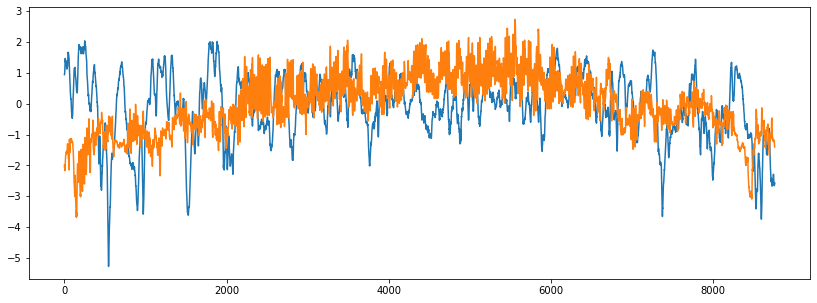

In [11]:
fig = plt.figure(figsize=(14,5))
plt.plot(train_Y_df)

Normalized 된 온도와 기압의 원래 값을 봅시다.

<AxesSubplot:title={'center':'p (mbar)'}, xlabel='Date Time'>

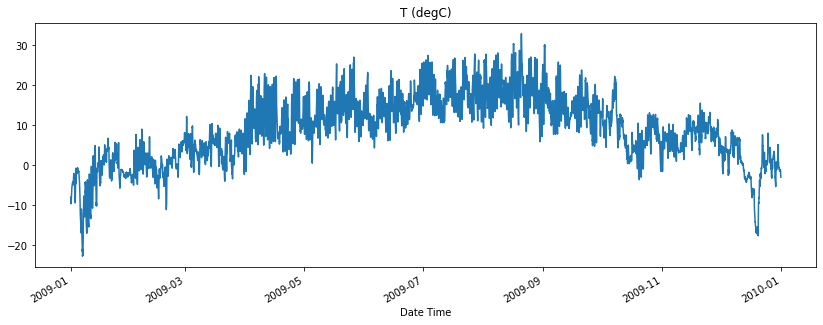

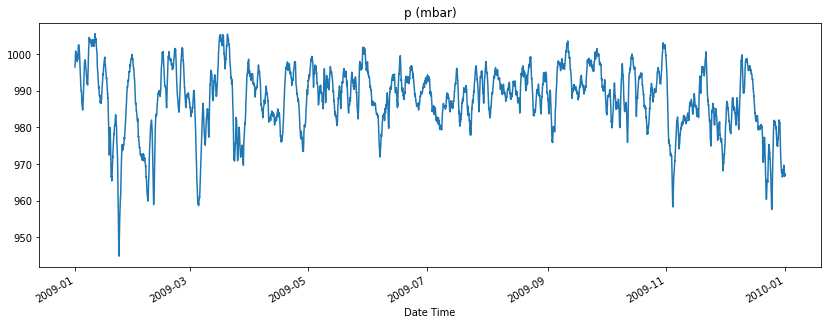

In [12]:
T_std = train_std['T (degC)']
T_mean = train_mean['T (degC)']

p_std = train_std['p (mbar)']
p_mean = train_mean['p (mbar)']

fig = plt.figure(figsize=(14,5))
plt.title('T (degC)')

plot_ = train_Y_df['T (degC)'] * T_std + T_mean
plot_.index = train_date_time[:idx_end+1]
plot_.plot()

fig = plt.figure(figsize=(14,5))
plt.title('p (mbar)')

plot_ = train_Y_df['p (mbar)'] * p_std + p_mean
plot_.index = train_date_time[:idx_end+1]
plot_.plot()


# LSTM model

- `sequence_length` : Batch data 때 정의하며 tuning 필요.
- `input_size` 는 U에 의해, `output_size`는 Y에 의해 불변. 모델 정의에 필요함.
- `hidden_size` : LSTM의 output size이며 MLP의 input size. tuning 필요.
- 그외 `num_layers`, MLP의 차원 및 layer 개수

In [13]:
class RNN(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size=100, num_layers=1):
        super().__init__()
        self.output_size = output_size
        
        self.rnn = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
         
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, 10),
            nn.ReLU(),            
            nn.Linear(10,output_size)
        )
        
        
    def forward(self, u , state=None, use_state=False):        
        
        if use_state:
            # 이전 hidden_state, cell_state가 존재할때, 입력으로 받는다.
            print("State is found! use h, c")            
            output, state = self.rnn(u, state)
        else:
            output, state = self.rnn(u)

        # MLP 의 입력으로 차원 변환.
        b, ll , hh  = output.shape
        output = output.reshape(b*ll, hh)
        output = self.linear(output)
        
        # output으로 차원 변환.
        output = output.reshape(b, ll, self.output_size)
        return output, state

In [14]:
input_size = tensor_u.shape[2]
batch_size = tensor_u.shape[0]
output_size = tensor_y.shape[2]

model = RNN(input_size, output_size, hidden_size=10, num_layers=3)
model


RNN(
  (rnn): LSTM(15, 10, num_layers=3, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

# Train loop

In [15]:
lr = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
epochs = 200
for i in range(1, epochs+1):
    model.train()
    
    output, _ = model(tensor_u)

    loss = criterion(output.view(-1,1), tensor_y.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # if i%25 == 0:
    print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

Epoch 1, Loss 1.07178
Epoch 2, Loss 1.05209
Epoch 3, Loss 1.03545
Epoch 4, Loss 1.01785
Epoch 5, Loss 1.00007
Epoch 6, Loss 0.97701
Epoch 7, Loss 0.94861
Epoch 8, Loss 0.91605
Epoch 9, Loss 0.88145
Epoch 10, Loss 0.84967
Epoch 11, Loss 0.82691
Epoch 12, Loss 0.80878
Epoch 13, Loss 0.79348
Epoch 14, Loss 0.78099
Epoch 15, Loss 0.76841
Epoch 16, Loss 0.75601
Epoch 17, Loss 0.74693
Epoch 18, Loss 0.73548
Epoch 19, Loss 0.72030
Epoch 20, Loss 0.70242
Epoch 21, Loss 0.68085
Epoch 22, Loss 0.65843
Epoch 23, Loss 0.64009
Epoch 24, Loss 0.62298
Epoch 25, Loss 0.60248
Epoch 26, Loss 0.58355
Epoch 27, Loss 0.56653
Epoch 28, Loss 0.54757
Epoch 29, Loss 0.52986
Epoch 30, Loss 0.51415
Epoch 31, Loss 0.49479
Epoch 32, Loss 0.47481
Epoch 33, Loss 0.45742
Epoch 34, Loss 0.43801
Epoch 35, Loss 0.41787
Epoch 36, Loss 0.39532
Epoch 37, Loss 0.37140
Epoch 38, Loss 0.34718
Epoch 39, Loss 0.33349
Epoch 40, Loss 0.31174
Epoch 41, Loss 0.28546
Epoch 42, Loss 0.25639
Epoch 43, Loss 0.23620
Epoch 44, Loss 0.230

# Validation 

prediction on validation set

In [16]:
val_df = val_df.reset_index()
val_df.pop('index')

0        49063
1        49064
2        49065
3        49066
4        49067
         ...  
14013    63076
14014    63077
14015    63078
14016    63079
14017    63080
Name: index, Length: 14018, dtype: int64

validation set 의 2번 째 주에 대해 prediction을 합니다.

In [17]:
val_idx_start = 24 * 7
val_idx_end =  24 * 7 * 2

sequence_length = val_idx_end - val_idx_start + 1


val_tensor_u, val_tensor_y, val_Y_df, val_U_df  = make_batch_from_df(val_df, val_idx_start, val_idx_end, sequence_length)

idx _start : 168 . idx_end : 336
Sequence Length : 169
train_range: range(168, 169)
U input : torch.Size([1, 169, 15])
Y input : torch.Size([1, 169, 2])


In [18]:
model.eval()

output,_ = model(val_tensor_u)

output = output.detach().numpy()

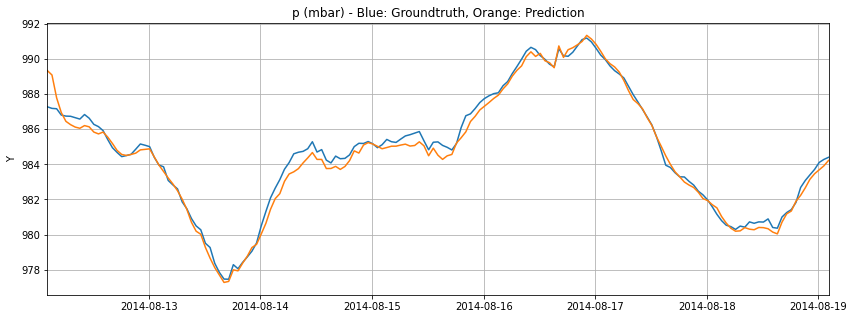

In [19]:
fig = plt.figure(figsize=(14,5))
plt.title('p (mbar) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['p (mbar)'][val_idx_start:val_idx_end+1] * p_std + p_mean
plot_gt.index = val_date_time[val_idx_start:val_idx_end+1] 

plot_pred = output[0][..., 0] * p_std + p_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start:val_idx_end+1], plot_pred)

plt.show()

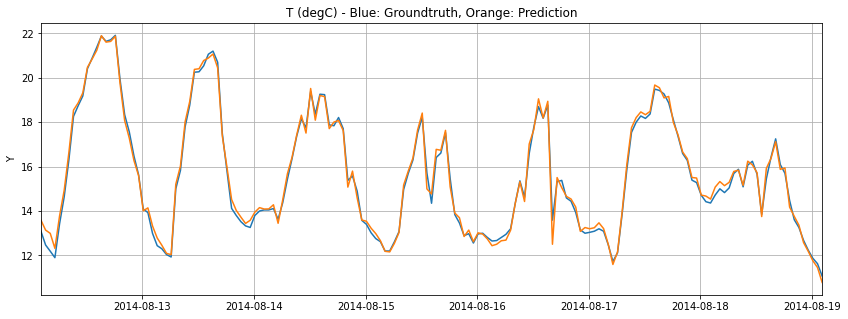

In [20]:
fig = plt.figure(figsize=(14,5))
plt.title('T (degC) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['T (degC)'][val_idx_start:val_idx_end+1] * T_std + T_mean
plot_gt.index = val_date_time[val_idx_start:val_idx_end+1] 

plot_pred = output[0][..., 1] * T_std + T_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start:val_idx_end+1], plot_pred)

plt.show()

## 2. Gain hidden_state and cell_state, then predict

validation set의 첫 번쨰 주 구간에서 prediction하고 `hidden_state`와 `cell_state`에서 이어서 두 번째 주 구간에 prediction 합니다.

In [21]:
val_idx_start = 0
val_idx_end =  24 * 7 

sequence_length = val_idx_end - val_idx_start + 1


val_tensor_u, val_tensor_y, val_Y_df, val_U_df  = make_batch_from_df(val_df, val_idx_start, val_idx_end, sequence_length)

idx _start : 0 . idx_end : 168
Sequence Length : 169
train_range: range(0, 1)
U input : torch.Size([1, 169, 15])
Y input : torch.Size([1, 169, 2])


In [22]:
model.eval()

output, state = model(val_tensor_u)

첫 번쨰 주에서 state (`hidden_state`와 `cell_state`)에서 부터 두 번째 주 구간에 prediction 합니다.

In [23]:
val_idx_start = 24 * 7
val_idx_end =  24 * 7 * 2

sequence_length = val_idx_end - val_idx_start + 1


val_tensor_u, val_tensor_y, val_Y_df, val_U_df  = make_batch_from_df(val_df, val_idx_start, val_idx_end, sequence_length)

idx _start : 168 . idx_end : 336
Sequence Length : 169
train_range: range(168, 169)
U input : torch.Size([1, 169, 15])
Y input : torch.Size([1, 169, 2])


In [24]:
model.eval()

output,_ = model(val_tensor_u, state=state, use_state=True)


output = output.detach().numpy()

State is found! use h, c


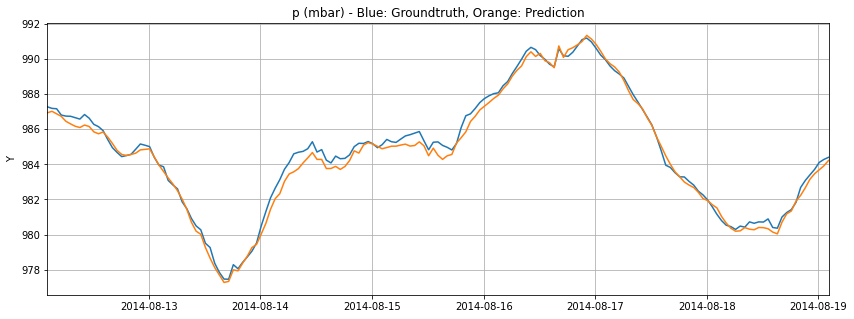

In [25]:
fig = plt.figure(figsize=(14,5))
plt.title('p (mbar) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['p (mbar)'][val_idx_start:val_idx_end+1] * p_std + p_mean
plot_gt.index = val_date_time[val_idx_start:val_idx_end+1] 

plot_pred = output[0][..., 0] * p_std + p_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start:val_idx_end+1], plot_pred)

plt.show()

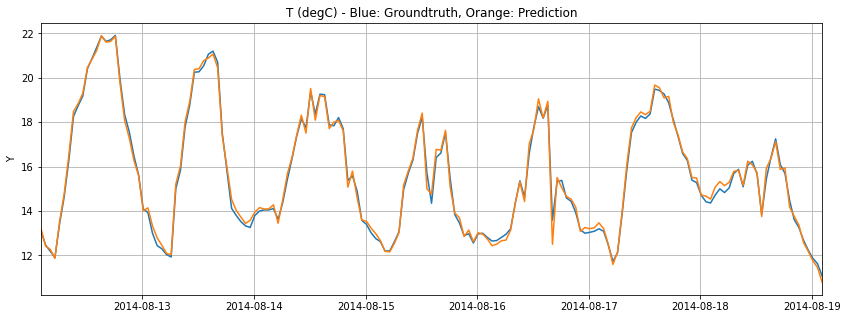

In [26]:
fig = plt.figure(figsize=(14,5))
plt.title('T (degC) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['T (degC)'][val_idx_start:val_idx_end+1] * T_std + T_mean
plot_gt.index = val_date_time[val_idx_start:val_idx_end+1] 

plot_pred = output[0][..., 1] * T_std + T_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start:val_idx_end+1], plot_pred)

plt.show()

## 3. Give nonsense hidden_state, cell_state at the beginning of prediction

In [27]:
## # for Vanilla RNN,
## state = torch.ones_like(state)*100

h_dummy, c_dummy = state[0], state[1]
h_dummy = torch.ones_like(h_dummy)*1000
print(h_dummy)

c_dummy = torch.ones_like(c_dummy)*1000
print(c_dummy)

state = (h_dummy, c_dummy)

tensor([[[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],

        [[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],

        [[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]]])
tensor([[[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],

        [[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],

        [[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]]])


In [28]:
model.eval()

output,_ = model(val_tensor_u, state = state, use_state = True)


output = output.detach().numpy()

State is found! use h, c


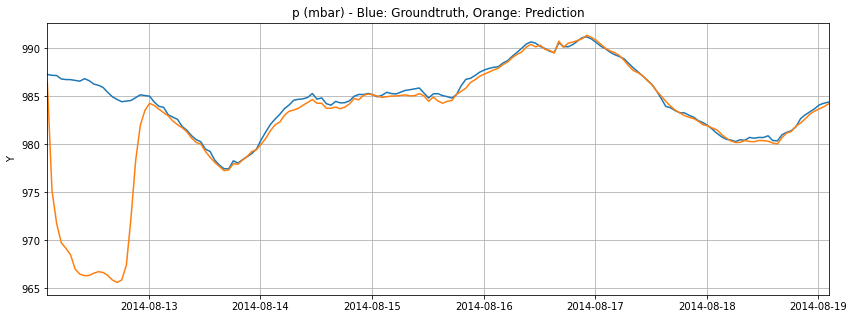

In [29]:
fig = plt.figure(figsize=(14,5))
plt.title('p (mbar) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['p (mbar)'][val_idx_start:val_idx_end+1] * p_std + p_mean
plot_gt.index = val_date_time[val_idx_start:val_idx_end+1] 

plot_pred = output[0][..., 0] * p_std + p_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start:val_idx_end+1], plot_pred)

plt.show()

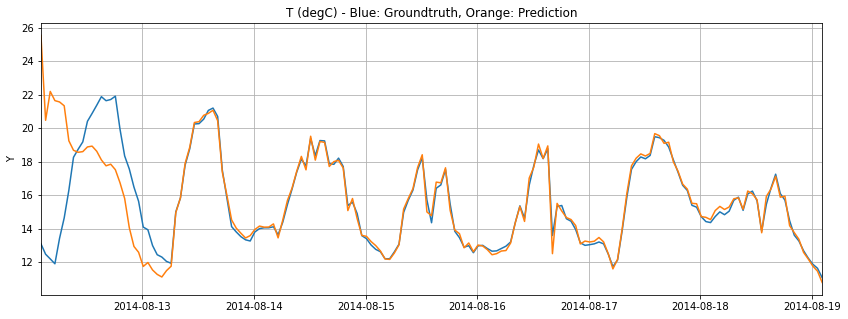

In [30]:
fig = plt.figure(figsize=(14,5))
plt.title('T (degC) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['T (degC)'][val_idx_start:val_idx_end+1] * T_std + T_mean
plot_gt.index = val_date_time[val_idx_start:val_idx_end+1] 

plot_pred = output[0][..., 1] * T_std + T_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start:val_idx_end+1], plot_pred)

plt.show()